In [2]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/data/des81.b/data/tavangar/streams/code')
import glob

import numpy as np
import healpy as hp
import fitsio as fits
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as nd
from utils import load_infiles
import pandas as pd
import pickle
import scipy.signal as signal

import ugali
from ugali import isochrone

import skymap, skymap.survey
from skymap.utils import cel2gal, gal2cel
from skymap.utils import setdefaults

from streamlib import skymap_factory
import streamlib
import results
import rotation_matrix
import plot_hess
import filter_data

import polyfit2d
from numpy.polynomial import polynomial

import importlib
import imp

import region_plot

In [3]:
def plot_pretty(dpi=175, fontsize=25, labelsize=15, figsize=(10, 8), tex=True):
    # import pyplot and set some parameters to make plots prettier
    plt.rc('savefig', dpi=dpi)
    plt.rc('text', usetex=tex)
    plt.rc('font', size=fontsize)
    plt.rc('xtick.major', pad=1)
    plt.rc('xtick.minor', pad=1)
    plt.rc('ytick.major', pad=1)
    plt.rc('ytick.minor', pad=1)
    plt.rc('figure', figsize=figsize)
    mpl.rcParams['xtick.labelsize'] = labelsize
    mpl.rcParams['ytick.labelsize'] = labelsize
    mpl.rcParams.update({'figure.autolayout': True})
    
plot_pretty(fontsize=15)

In [4]:
sfd = hp.read_map('lambda_sfd_ebv.fits')
nside = hp.get_nside(sfd)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
sfd = sfd[galpix]

#planck = fitsio.read('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')['I_ML_FULL']
planck = hp.read_map('COM_CompMap_ThermalDust-commander_2048_R2.00.fits')
nside = hp.get_nside(planck)
ra,dec = hp.pix2ang(nside,np.arange(hp.nside2npix(nside)),lonlat=True)
galpix = hp.ang2pix(nside,*cel2gal(ra,dec),lonlat=True)
planck = planck[galpix]

NSIDE = 512
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


## Phoenix Data

In [5]:
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DES_Y6_iso_hpxcube_z0.0004_a13.0_gmax24.0_gmin3p5_E3_C0p01p075.fits.gz...
Skipping fracdet...


In [6]:
full_data = np.load('y6_reduced_data.npy')

7.0


(7.4, -9)

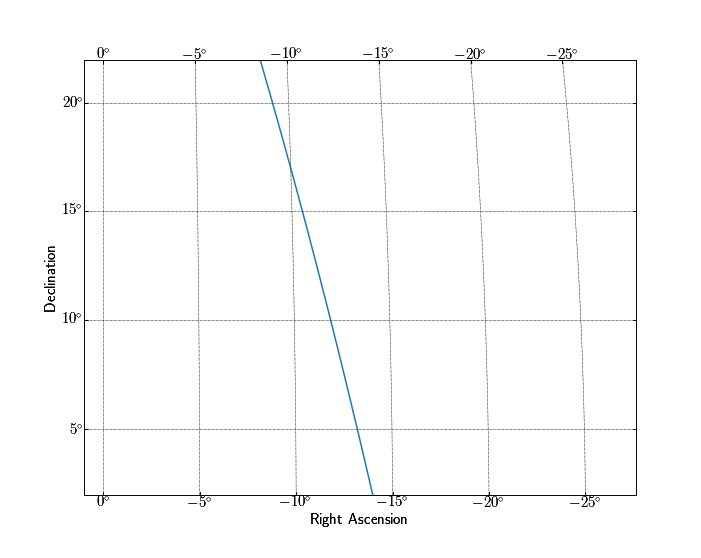

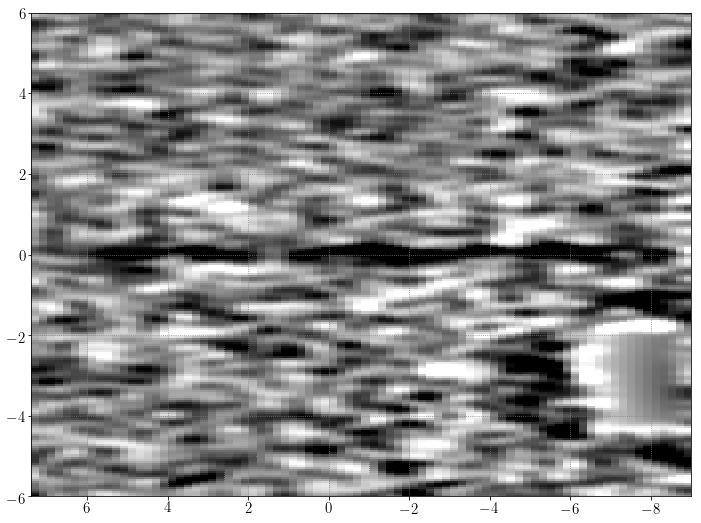

In [11]:
reload(region_plot)
d = region_plot.prepare_hpxmap(16.2, hpxcube, fracdet, modulus)
phoenix_ends = [27.9, -42.7, 20.1, -55.3]   
pp1, pp2, vv, smooth_res, smooth, vv_mask, vv_res = region_plot.stream_coord_spatial(d, phoenix_ends, full_data, 
                                                                      deg=5, sigma=0.15, stream = 'Phoenix')
plt.xlim(7.4, -9)

(7.4, -9)

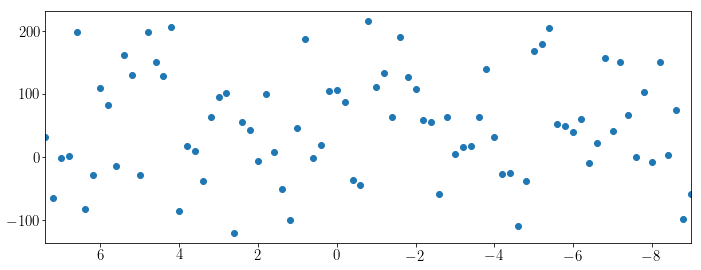

In [12]:
plt.figure(figsize=(10,4))
phi1 = pp1[0]
nstars = np.sum(vv_res[110:130], axis=0) #from phi2 = (-0.5,0.5)
binwidth=0.2
nstars = nstars/binwidth
plt.scatter(phi1, nstars)

pcoefs=np.polyfit(phi1,nstars,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1)
nstars_detrend=nstars-polydat
plt.xlim(7.4, -9)

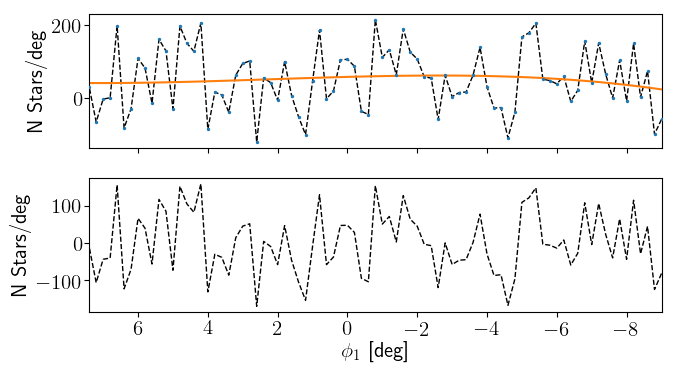

In [13]:
fig,(ax1,ax2)=plt.subplots(2,1,dpi=100, figsize=(7,4), sharex=True)
ax1.scatter(phi1,nstars, s=2, zorder=10)
ax1.plot(phi1,nstars, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1,polydat, label="3rd order fit", color='tab:orange')
#ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1,nstars_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(7.4, -9)
plt.subplots_adjust(hspace=0)


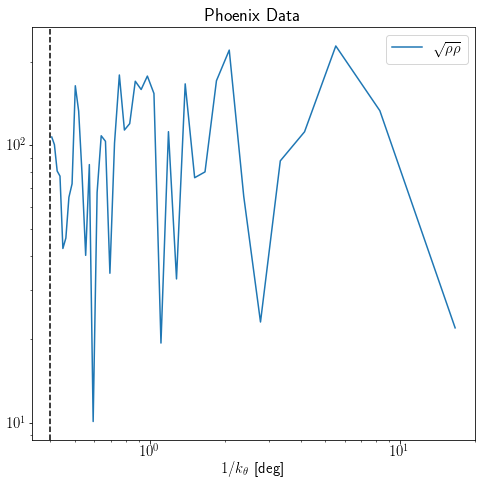

In [14]:
freq,power=signal.csd(nstars_detrend,nstars_detrend, nperseg=len(nstars_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))

fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Phoenix Data')
plt.show()

## Phoenix Model

In [24]:
phi1_mod = np.load('model_arrays/pp1_full_phoenix_tall.npy')[:,1:-1][80]
nstars_mod = np.load('model_arrays/phoenix_int1d_map_final_test7.npy')[80]
#phi1_mod = phi1_mod[5:-5]
#nstars_mod = nstars_mod[5:-5]
pcoefs=np.polyfit(phi1_mod,nstars_mod,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1_mod)
nstars_mod_detrend=nstars_mod-polydat

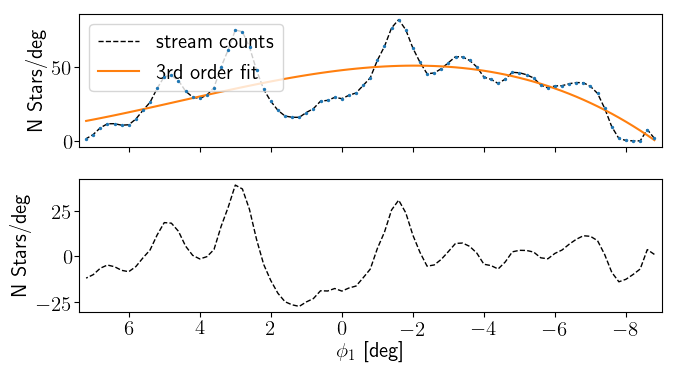

In [25]:
fig,(ax1,ax2)=plt.subplots(2,1,dpi=100, figsize=(7,4), sharex=True)
ax1.scatter(phi1_mod,nstars_mod, s=2, zorder=10)
ax1.plot(phi1_mod,nstars_mod, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1_mod,polydat, label="3rd order fit", color='tab:orange')
ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1_mod,nstars_mod_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(7.4, -9)
plt.subplots_adjust(hspace=0)

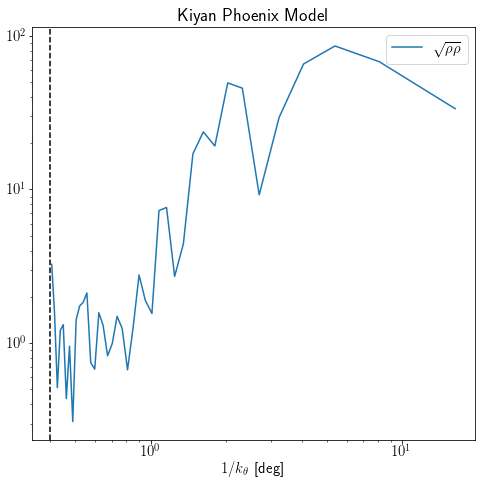

In [26]:
freq,power=signal.csd(nstars_mod_detrend,nstars_mod_detrend, nperseg=len(nstars_mod_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))


fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Kiyan Phoenix Model')
plt.show()

## Atlas Sergey Data

In [27]:
import h5py
filename = "power_spectra/to_kian.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    
    for key in f.keys():
        print(key)
        
    hh = np.transpose(f['hh'].value)
    print(f['maxx1'].value)

Keys: [u'XMOD', u'hh', u'maxx1', u'maxy', u'minx', u'minx1', u'miny']
XMOD
hh
maxx1
maxy
minx
minx1
miny
10.0


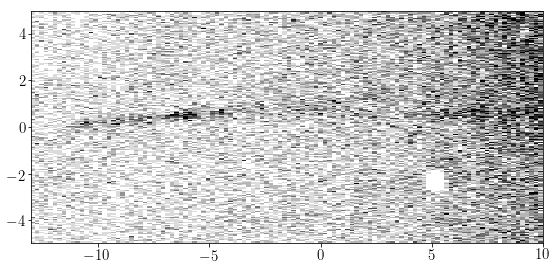

In [28]:
pixscale1=0.2
pixscale2=0.05
pixscale = 0.05
sigma = 0.1

phi1min, phi1max = -13, 10
phi2min, phi2max = -5, 5
    
nphi1pix = (phi1max-phi1min)/pixscale1 # for a 0.2 x 0.05 pixel size
nphi2pix = (phi2max-phi2min)/pixscale2 # for a 0.2 x 0.05 pixel size

p1 = np.linspace(-13,10,nphi1pix)
p2 = np.linspace(-5,5,nphi2pix)
pp1,pp2 = np.meshgrid(p1,p2)
hh_smooth = nd.gaussian_filter(hh, sigma=0)
plt.figure(figsize=(8,4))
plt.pcolormesh(pp1, pp2, hh_smooth, cmap='gray_r', vmax = 7)

(-13, 10)

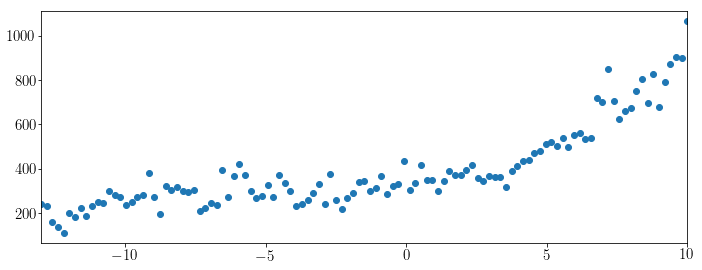

In [29]:
plt.figure(figsize=(10,4))
phi1_AS_data = pp1[0]
smooth_hh = nd.gaussian_filter(hh, sigma=0.15/0.1)
nstars_AS_data = np.sum(hh[90:130], axis=0)
binwidth=0.2
nstars_AS_data = nstars_AS_data/binwidth
plt.scatter(phi1_AS_data, nstars_AS_data)

pcoefs=np.polyfit(phi1_AS_data,nstars_AS_data,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1_AS_data)
nstars_AS_data_detrend=nstars_AS_data-polydat
plt.xlim(-13, 10)

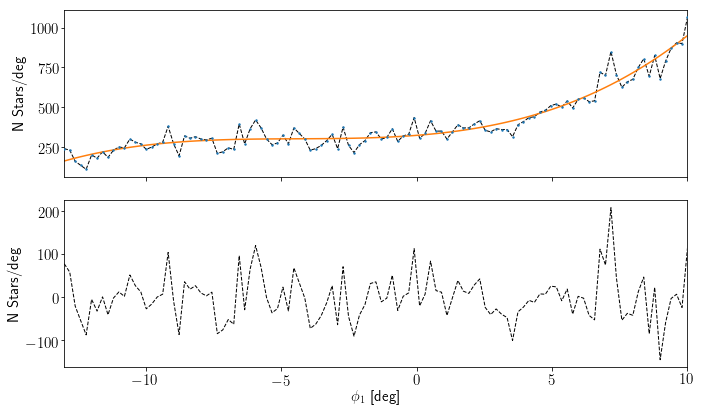

In [30]:
fig,(ax1,ax2)=plt.subplots(2,1, figsize=(10,6), sharex=True)
ax1.scatter(phi1_AS_data,nstars_AS_data, s=2, zorder=10)
ax1.plot(phi1_AS_data,nstars_AS_data, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1_AS_data,polydat, label="3rd order fit", color='tab:orange')
#ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1_AS_data,nstars_AS_data_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(-13, 10)
plt.subplots_adjust(hspace=0)

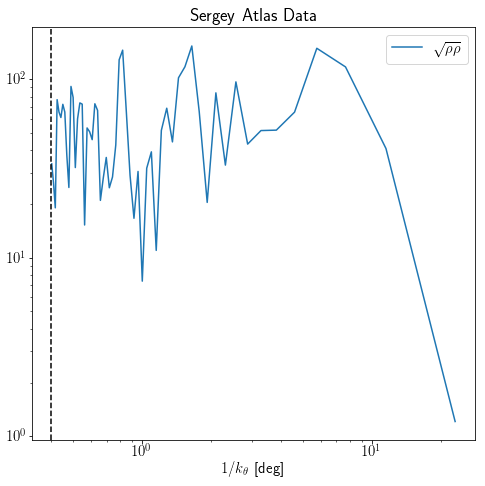

In [31]:
freq,power=signal.csd(nstars_AS_data_detrend,nstars_AS_data_detrend, nperseg=len(nstars_AS_data_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))


fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Sergey Atlas Data')
plt.show()

## Atlas Sergey Model

In [32]:
from scipy import interpolate
phi1_AS_mod_init = []
AS_int = fits.read('power_spectra/pub_int_atlas.fits')
##this gives my the values at the nodes, need to create cubic spline to get the actual fit and then I can apply PS

nstars_AS_mod_init = []
for i in range(len(AS_int)):
    phi1_AS_mod_init = np.append(phi1_AS_mod_init, AS_int[i][0])
    nstars_AS_mod_init = np.append(nstars_AS_mod_init, AS_int[i][1])
tck = interpolate.splrep(phi1_AS_mod_init, nstars_AS_mod_init)

nstars_AS_mod = []
for i in range(len(phi1_AS_data)):
    nstars_AS_mod = np.append(nstars_AS_mod, interpolate.splev(phi1_AS_data[i], tck))

phi1_AS_mod = phi1_AS_data
nstars_AS_mod = np.e**nstars_AS_mod
#phi1_mod = phi1_mod[5:-5]
#nstars_mod = nstars_mod[5:-5]
pcoefs=np.polyfit(phi1_AS_mod,nstars_AS_mod,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1_AS_mod)
nstars_AS_mod_detrend=nstars_AS_mod-polydat

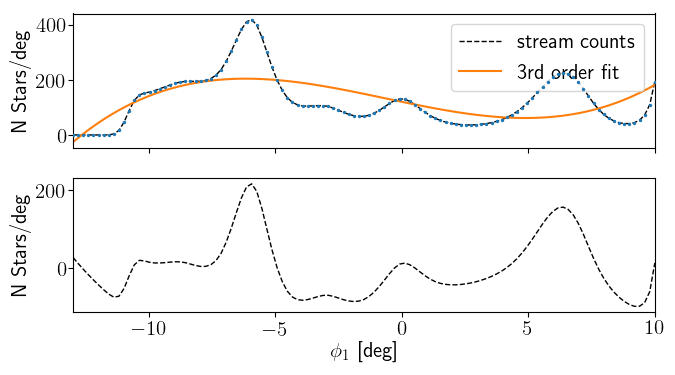

In [33]:
fig,(ax1,ax2)=plt.subplots(2,1,dpi=100, figsize=(7,4), sharex=True)
ax1.scatter(phi1_AS_mod,nstars_AS_mod, s=2, zorder=10)
ax1.plot(phi1_AS_mod,nstars_AS_mod, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1_AS_mod,polydat, label="3rd order fit", color='tab:orange')
ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1_AS_mod,nstars_AS_mod_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(-13, 10)
plt.subplots_adjust(hspace=0)

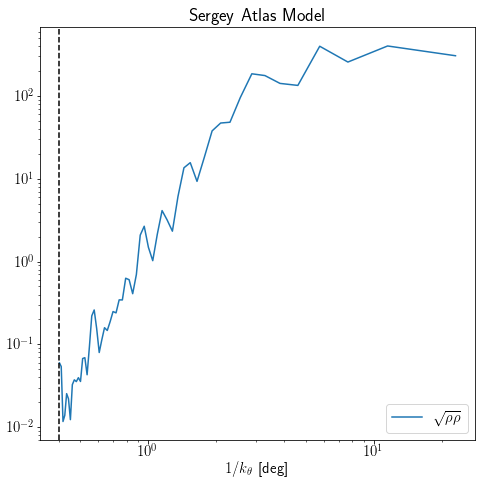

In [34]:
freq,power=signal.csd(nstars_AS_mod_detrend,nstars_AS_mod_detrend, nperseg=len(nstars_AS_mod_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))


fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Sergey Atlas Model')
plt.show()

## ATLAS Kiyan Data

In [35]:
#filenames = glob.glob('/home/s1/kadrlica/projects/y3a2/data/gold/v2.0/healpix/*.fits')
#full_data = load_infiles(filenames,columns=[
#    'RA','DEC','SOF_PSF_MAG_G','SOF_PSF_MAG_R','SOF_PSF_MAG_I', 'EXTENDED_CLASS_MASH_SOF'],multiproc=8)
print('hi')

hi


In [36]:
#full_data = full_data[full_data['EXTENDED_CLASS_MASH_SOF'] < 2]
#full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G'] < 24.0)]# & (full_data['SOF_PSF_MAG_CORRECTED_G'] > 20.2)]
#full_data = full_data[(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] < 1)
#          &(full_data['SOF_PSF_MAG_CORRECTED_G']-full_data['SOF_PSF_MAG_CORRECTED_R'] > 0)]
#print(len(full_data))
#np.save('y3_reduced_data.npy', full_data)
print('hi')

hi


In [37]:
#full_data_y3 = np.load('y3_reduced_data.npy')
full_data = np.load('y6_reduced_data.npy')
hpxcube, fracdet, modulus = region_plot.load_hpxcube(
    '/data/des81.b/data/tavangar/streams/des/DESY3_iso_hpxcube_z0.0007_a11.0_gmax23_gmin3p4_E2_C0p050p1.fits.gz')

Reading /data/des81.b/data/tavangar/streams/des/DESY3_iso_hpxcube_z0.0007_a11.0_gmax23_gmin3p4_E2_C0p050p1.fits.gz...
Skipping fracdet...


6.0


(16, -10)

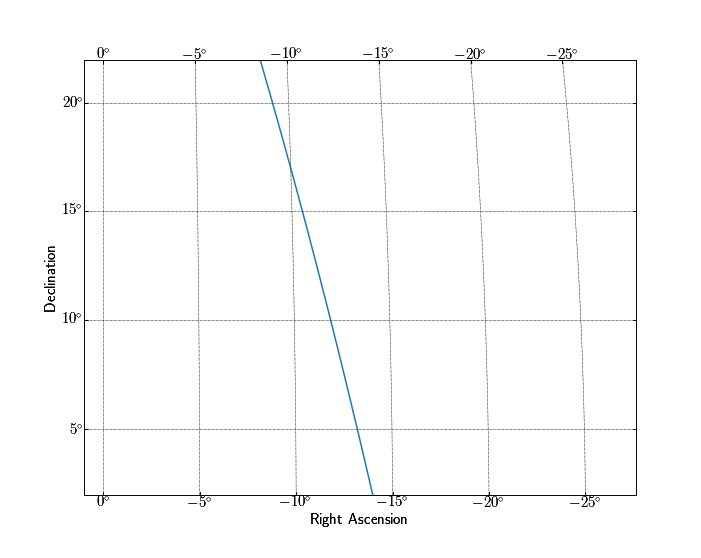

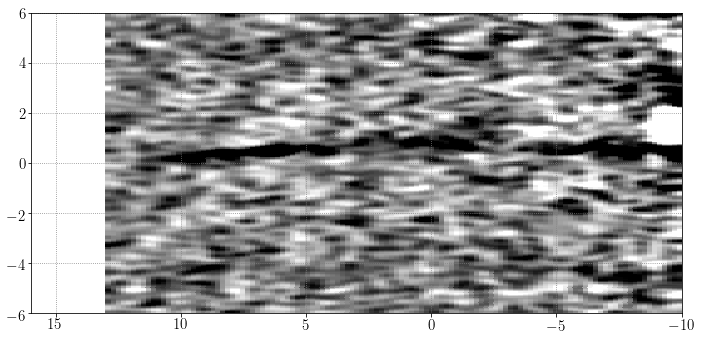

In [43]:
reload(region_plot)
d = region_plot.prepare_hpxmap(16.4, hpxcube, fracdet, modulus)
atlas_ends = [30.7, -33.2, 9.3, -20.9] 
pp1, pp2, vv, smooth_res, smooth, vv_mask, vv_res = region_plot.stream_coord_spatial(d, atlas_ends, full_data, 
                                                                      deg=5, sigma=0.15, stream = 'Atlas')
plt.xlim(16, -10)

(-10, 10)

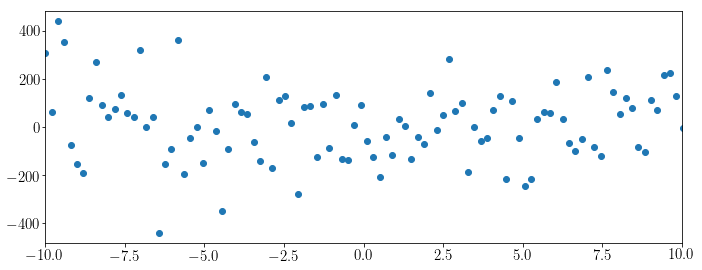

In [44]:
plt.figure(figsize=(10,4))
phi1_AK_data = pp1[0]
nstars_AK_data = np.sum(vv_res[90:130], axis=0)
binwidth=0.2
nstars_AK_data = nstars_AK_data/binwidth
plt.scatter(phi1_AK_data, nstars_AK_data)

pcoefs=np.polyfit(phi1_AK_data,nstars_AK_data,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1_AK_data)
nstars_AK_data_detrend=nstars_AK_data-polydat
plt.xlim(-10, 10)

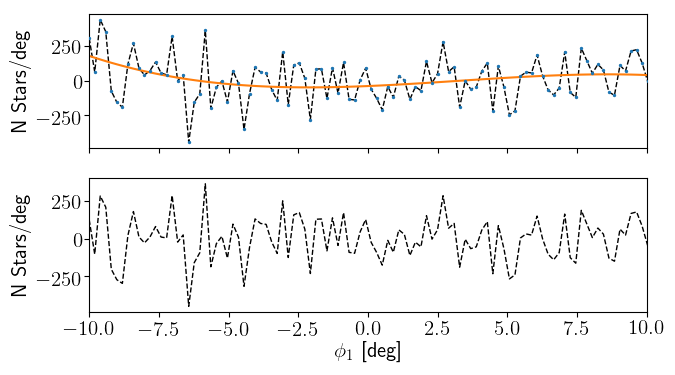

In [45]:
fig,(ax1,ax2)=plt.subplots(2,1, dpi=100, figsize=(7,4), sharex=True)
ax1.scatter(phi1_AK_data,nstars_AK_data, s=2, zorder=10)
ax1.plot(phi1_AK_data,nstars_AK_data, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1_AK_data,polydat, label="3rd order fit", color='tab:orange')
#ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1_AK_data,nstars_AK_data_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(-10, 10)
plt.subplots_adjust(hspace=0)

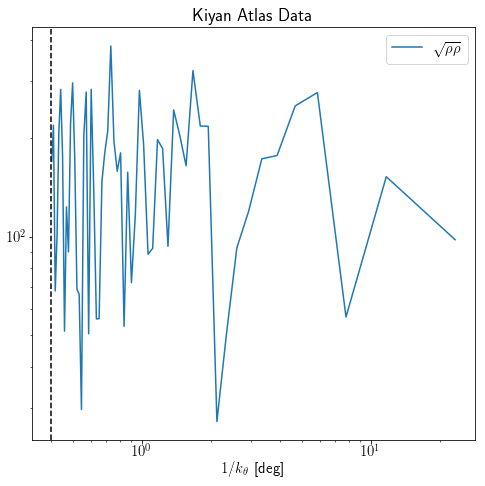

In [46]:
freq,power=signal.csd(nstars_AK_data_detrend,nstars_AK_data_detrend, nperseg=len(nstars_AK_data_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))


fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Kiyan Atlas Data')
plt.show()

## ATLAS Kiyan Model

In [47]:
phi1_AK_mod = np.load('power_spectra/pp1_atlas.npy')
nstars_AK_mod = np.load('power_spectra/int1dmap0_atlas.npy')
#phi1_mod = phi1_mod[5:-5]
#nstars_mod = nstars_mod[5:-5]
pcoefs=np.polyfit(phi1_AK_mod,nstars_AK_mod,3)
pfit=np.poly1d(pcoefs)
polydat=pfit(phi1_AK_mod)
nstars_AK_mod_detrend=nstars_AK_mod-polydat

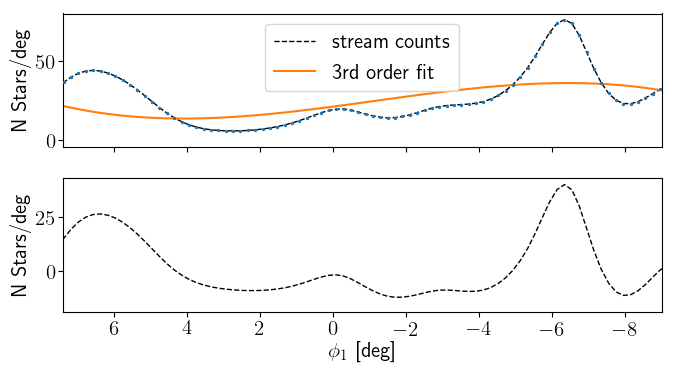

In [48]:
fig,(ax1,ax2)=plt.subplots(2,1,dpi=100, figsize=(7,4), sharex=True)
ax1.scatter(phi1_AK_mod,nstars_AK_mod, s=2, zorder=10)
ax1.plot(phi1_AK_mod,nstars_AK_mod, label="stream counts", ls='dashed', lw=1, color="black")
ax1.plot(phi1_AK_mod,polydat, label="3rd order fit", color='tab:orange')
ax1.legend()
ax1.set_ylabel("N Stars/deg")

#ax2.scatter(phi1,nstars-polydat, label="stream counts", s=2, zorder=10)
ax2.plot(phi1_AK_mod,nstars_AK_mod_detrend, label="detrended stream counts", ls='dashed', lw=1, color="black")
ax2.set_xlabel(r"$\phi_1$ [deg]")
ax2.set_ylabel("N Stars/deg")
ax2.set_xlim(7.4, -9)
plt.subplots_adjust(hspace=0)

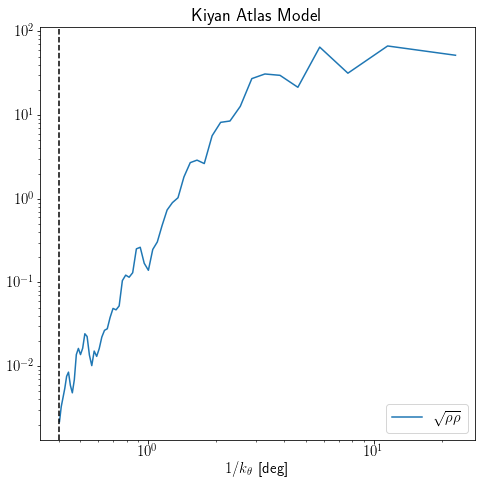

In [49]:
freq,power=signal.csd(nstars_AK_mod_detrend,nstars_AK_mod_detrend, nperseg=len(nstars_AK_mod_detrend))
sel=(freq > 0)
invk=1/freq[sel]*binwidth
powerplt=np.sqrt(np.abs(power[sel]))


fig=plt.figure(figsize=(7,7))
plt.plot(invk,powerplt, label=r'$\sqrt{\rho\rho}$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.axvline(0.4, ls="dashed", color="black")
plt.xlabel(r"$1/k_\theta$ [deg]")
plt.title('Kiyan Atlas Model')
plt.show()

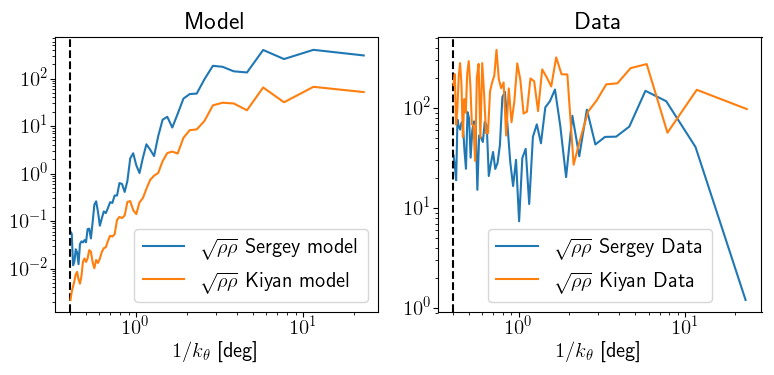

In [50]:
freq,power=signal.csd(nstars_AK_mod_detrend,nstars_AK_mod_detrend, nperseg=len(nstars_AK_mod_detrend))
sel=(freq > 0)
invk_AKM=1/freq[sel]*binwidth
powerplt_AKM=np.sqrt(np.abs(power[sel]))

freq,power=signal.csd(nstars_AS_mod_detrend,nstars_AS_mod_detrend, nperseg=len(nstars_AS_mod_detrend))
sel=(freq > 0)
invk_ASM=1/freq[sel]*binwidth
powerplt_ASM=np.sqrt(np.abs(power[sel]))

freq,power=signal.csd(nstars_AK_data_detrend,nstars_AK_data_detrend, nperseg=len(nstars_AK_data_detrend))
sel=(freq > 0)
invk_AKD=1/freq[sel]*binwidth
powerplt_AKD=np.sqrt(np.abs(power[sel]))

freq,power=signal.csd(nstars_AS_data_detrend,nstars_AS_data_detrend, nperseg=len(nstars_AS_data_detrend))
sel=(freq > 0)
invk_ASD=1/freq[sel]*binwidth
powerplt_ASD=np.sqrt(np.abs(power[sel]))

fig, (ax1, ax2) =plt.subplots(1,2, dpi=100, figsize=(8,4))
ax1.plot(invk_ASM,powerplt_ASM, label=r'$\sqrt{\rho\rho}$ Sergey model')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axvline(0.4, ls="dashed", color="black")
ax1.set_xlabel(r"$1/k_\theta$ [deg]")

ax2.plot(invk_ASD,powerplt_ASD, label=r'$\sqrt{\rho\rho}$ Sergey Data')
ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.axvline(0.4, ls="dashed", color="black")
ax2.set_xlabel(r"$1/k_\theta$ [deg]")
ax2.set_title('Sergey Atlas Data')

ax1.plot(invk_AKM,powerplt_AKM, label=r'$\sqrt{\rho\rho}$ Kiyan model')
ax1.set_title('Model')
ax1.legend()

ax2.plot(invk_AKD,powerplt_AKD, label=r'$\sqrt{\rho\rho}$ Kiyan Data')
ax2.legend()
ax2.set_title('Data')
plt.savefig('power_spectrum_array.jpg')
plt.show()

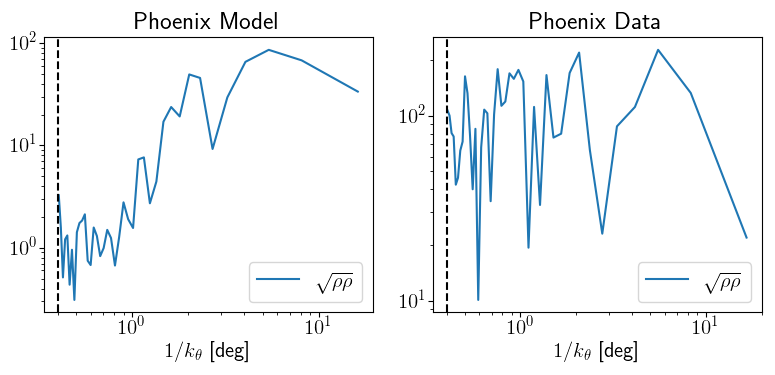

In [51]:
freq,power=signal.csd(nstars_detrend,nstars_detrend, nperseg=len(nstars_detrend))
sel=(freq > 0)
invk_PD=1/freq[sel]*binwidth
powerplt_PD=np.sqrt(np.abs(power[sel]))

freq,power=signal.csd(nstars_mod_detrend,nstars_mod_detrend, nperseg=len(nstars_mod_detrend))
sel=(freq > 0)
invk_PM=1/freq[sel]*binwidth
powerplt_PM=np.sqrt(np.abs(power[sel]))


fig, ((ax1, ax2)) =plt.subplots(1,2, dpi=100, figsize=(8,4))
ax1.plot(invk_PM,powerplt_PM, label=r'$\sqrt{\rho\rho}$')
ax1.legend()
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axvline(0.4, ls="dashed", color="black")
ax1.set_xlabel(r"$1/k_\theta$ [deg]")
ax1.set_title('Phoenix Model')

ax2.plot(invk_PD,powerplt_PD, label=r'$\sqrt{\rho\rho}$')
ax2.legend()
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.axvline(0.4, ls="dashed", color="black")
ax2.set_xlabel(r"$1/k_\theta$ [deg]")
ax2.set_title('Phoenix Data')
plt.show()

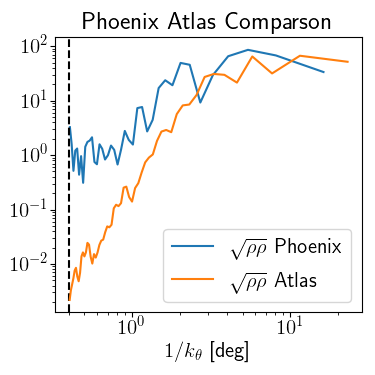

In [52]:
freq,power=signal.csd(nstars_AK_mod_detrend,nstars_AK_mod_detrend, nperseg=len(nstars_AK_mod_detrend))
sel=(freq > 0)
invk_AKM=1/freq[sel]*binwidth
powerplt_AKM=np.sqrt(np.abs(power[sel]))

freq,power=signal.csd(nstars_mod_detrend,nstars_mod_detrend, nperseg=len(nstars_mod_detrend))
sel=(freq > 0)
invk_PM=1/freq[sel]*binwidth
powerplt_PM=np.sqrt(np.abs(power[sel]))


fig, (ax1) =plt.subplots(1,1, dpi=100, figsize=(4,4), sharex=True)
ax1.plot(invk_PM,powerplt_PM, label=r'$\sqrt{\rho\rho}$ Phoenix')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.axvline(0.4, ls="dashed", color="black")
ax1.set_xlabel(r"$1/k_\theta$ [deg]")

ax1.plot(invk_AKM,powerplt_AKM, label=r'$\sqrt{\rho\rho}$ Atlas')
ax1.legend()
ax1.set_title('Phoenix Atlas Comparson')
plt.savefig('phoenix_atlas_power.jpg')
plt.show()